## **“Dinámica de la infección por Virus Sincicial Respiratorio en el contexto de COVID-19 en la Región Metropolitana de Buenos Aires”**

El objetivo de este estudio es determinar la carga de enfermedad por RSV en el contexto pandemico de COVID 19 en el AMBA.

Se recolectan datos de ingresos hospitalarios de pacientes menores a 5 años, cuyo ingreso haya sido debido a alguna enfermedad respiratoria, y hayan tenido analisis del virus sincicial respiratorio. Los datos provienen de 4 hospitales diferentes, que abarcan la Capital Federal y gran parte del Gran Buenos Aires. Al momento de analizar los datos, los mismos se encuentran en constante actualizacion (ya que el estudio esta en curso), es por eso que la recoleccion se hace mediante la API.


En este momento contamos con datos de ~8400 ingresos hospitalarios, y estimamos tener alrededor de 10000 al culminar el estudio.
El objetivo de este analisis, es crear un algoritmo de prediccion, en el cual podamos determinar cuales son los pacientes que tengan mas chances de ingresar a terapia intensiva (UTI).
De esta manera podriamos preveer si un paciente necesitara ocupar una cama de terapia, y de esa manera intentar optimizar los tiempos y el espacio. Por eso nuestra variable objetivo sera si los pacientes necesitaron ingresar a terapia o no.

El dataset tiene un total de 180 columnas, y por eso vamos a tratar de disminuir la cantidad al menor numero posible.

In [260]:
# Primero importamos las librerias que podriamos llegar a necesitar para el analisis
import pandas as pd
import numpy as np
import csv
from credenciales import credenciales
import requests
from prettytable import PrettyTable
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing  
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
import xgboost 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [261]:
#Recolectamos los datos de la herramienta online, en donde estan alojados los datos
data = {
    'token': credenciales.get("REDCAP"),
    'content': 'report',
    'format': 'csv',
    'report_id': '122',
    'csvDelimiter': ';',
    'rawOrLabel': 'raw',
    'rawOrLabelHeaders': 'raw',
    'exportCheckboxLabel': 'true',
    'returnFormat': 'csv'
}
r = requests.post('https://redcap.infant.org.ar/es/api/',data=data)
print('HTTP Status: ' + str(r.status_code))
lines = r.text.splitlines()
reader = csv.reader(lines)
for row in reader:
    with open('TodosLosDatos.csv', 'w', newline='', encoding="utf-8") as csvfile:
        spamwriter = csv.writer(csvfile,quotechar=',')
        for row in reader:
            spamwriter.writerow(row)  


HTTP Status: 200


In [262]:
data = 'TodosLosDatos.csv'
df = pd.read_csv(data, sep=';', names=  ['record_id','hospital','cobertura','derivacion','deriv_ap','fecha_ingresoderiv','fecha_ingreso','fecha_alta_irab','int_previas','n_internaciones','fecha_ultint','fecha_de_nacimiento','edad_gest','sexo','partido','localidad','direccion','altura','entrecalles1','entrecalles2','codigo_postal','areaprog','hipox_taquipn','dispositivo_o2___1','dispositivo_o2___2','dispositivo_o2___3','dispositivo_o2___4','dispositivo_o2___5','dispositivo_o2___6','sx_ingreso___0','sx_ingreso___1','sx_ingreso___2','sx_ingreso___3','sx_ingreso___4','sx_ingreso___5','sx_ingreso___6','sx_ingreso___7','sx_ingreso___8','sx_ingreso___9','fecha_sxrespi','dx_respi___1','dx_respi___2','dx_respi___3','dx_respi___4','dx_respi___5','dx_respi___6','dx_respi___7','dx_respi___0','otro_dx','complicaciones___0','complicaciones___1','complicaciones___2','complicaciones___3','complicaciones___4','complicaciones___5','complicaciones___6','complicaciones___7','complicaciones___8','complicaciones___9','complicaciones___10','complicaciones___11','comorbilidades___0','comorbilidades___1','comorbilidades___2','comorbilidades___3','comorbilidades___4','comorbilidades___5','comorbilidades___6','comorbilidades___7','comorbilidades___8','comorbilidades___9','comorbilidades___10','comorbilidades___11','comorbilidades___12','comorbilidades___13','comorbilidades___14','otra_comorb','test_vsr','fecha_test1vsr','resultado_vsr1','tecnica_vsr1','otros_testvsr','fecha_test2vsr','resultado_vsr2','tecnica_vsr2','fecha_test3vsr','resultado_vsr3','tecnica_vsr3','test_covid','fecha_testcovid','resultado_covid','tecnica_covid','test_viro','resultado_viro___0','resultado_viro___1','resultado_viro___2','resultado_viro___3','resultado_viro___4','resultado_viro___5','resultado_viro___6','resultado_viro_otro','test_bordetella','resultado_bordetella','hmc','resultado_hmc___0','resultado_hmc___1','resultado_hmc___2','resultado_hmc___3','resultado_hmc___4','resultado_hmc___5','resultado_hmc___6','resultado_hmc___7','resultado_hmc___8','resultado_hmc_otro','cultivo_pleural','resultado_liqpleural___0','resultado_liqpleural___1','resultado_liqpleural___2','resultado_liqpleural___3','resultado_liqpleural___4','resultado_liqpleural___5','resultado_liqpleural___6','resultado_liqpleural___7','resultado_liqpleural___8','resultado_liqpleural_otro','cultivo_lcr','resultado_lcr___0','resultado_lcr___1','resultado_lcr___2','resultado_lcr___3','resultado_lcr___4','resultado_lcr___5','resultado_lcr___6','resultado_lcr___7','resultado_lcr___8','resultado_lcr___9','resultado_lcr_otro','cultivo_at','resultado_at___0','resultado_at___1','resultado_at___2','resultado_at___3','resultado_at___4','resultado_at___5','resultado_at___6','resultado_at___7','resultado_at___8','resultado_at___9','resultado_at___10','resultado_at___11','resultado_at___12','resultado_at___13','resultado_at_otro','uti','fecha_in_uti','fecha_eg_uti','dx_egreso','comentarios','formcomplete','tpo_ia','tpo_ib','tpo_ic','tpo_id','tpo_ii','causa_ia','causa_ib','causa_ic','causa_id','causa_ii','oms_ia','oms_ib','oms_ic','oms_id','oms_ii','decode_ia','decode_ib','decode_ic','decode_id','decode_ii','formulario_de_extraccion_complete'])
df.head()

C:\Users\Emi\AppData\Local\Temp\ipykernel_9552\1133717862.py:2: DtypeWarning: Columns (9,19,124,136,164,165,169,170) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data, sep=';', names=  ['record_id','hospital','cobertura','derivacion','deriv_ap','fecha_ingresoderiv','fecha_ingreso','fecha_alta_irab','int_previas','n_internaciones','fecha_ultint','fecha_de_nacimiento','edad_gest','sexo','partido','localidad','direccion','altura','entrecalles1','entrecalles2','codigo_postal','areaprog','hipox_taquipn','dispositivo_o2___1','dispositivo_o2___2','dispositivo_o2___3','dispositivo_o2___4','dispositivo_o2___5','dispositivo_o2___6','sx_ingreso___0','sx_ingreso___1','sx_ingreso___2','sx_ingreso___3','sx_ingreso___4','sx_ingreso___5','sx_ingreso___6','sx_ingreso___7','sx_ingreso___8','sx_ingreso___9','fecha_sxrespi','dx_respi___1','dx_respi___2','dx_respi___3','dx_respi___4','dx_respi___5','dx_respi___6','dx_respi___7','dx_respi___0','otro_dx','compl

record_id  hospital  cobertura  derivacion  deriv_ap   
0  aaa-195-2018-00       4.0        0.0         0.0       NaN  \
1  aaa-264-2020-00       3.0        0.0         1.0       1.0   
2  aaa-264-2020-01       3.0        0.0         0.0       NaN   
3  aaa-306-2019-00       1.0        0.0         0.0       NaN   
4  aaa-437-2018-00       1.0        0.0         0.0       NaN   

  fecha_ingresoderiv fecha_ingreso fecha_alta_irab  int_previas   
0                NaN    2018-07-10      2018-07-18          0.0  \
1                NaN    2020-05-09      2020-05-21          0.0   
2                NaN    2020-10-22      2020-10-23          1.0   
3                NaN    2019-05-13      2019-05-21          0.0   
4                NaN    2018-06-21      2018-06-27          0.0   

  n_internaciones  ... oms_ib oms_ic  oms_id  oms_ii  decode_ia decode_ib   
0             NaN  ...    NaN    NaN     NaN     NaN        NaN       NaN  \
1             NaN  ...    NaN    NaN     NaN     NaN        NaN       NaN   
2               1  ...    NaN    NaN     NaN     NaN        NaN       NaN   
3             NaN  ...    NaN    NaN     NaN     NaN        NaN       NaN   
4             NaN  ...    NaN    NaN     NaN     NaN        NaN       NaN   

  decode_ic  decode_id decode_ii formulario_de_extraccion_complete  
0       NaN        NaN       NaN                                 2  
1       NaN        NaN       NaN                                 2  
2       NaN        NaN       NaN                                 2  
3       NaN        NaN       NaN                                 2  
4       NaN        NaN       NaN                                 2  

[5 rows x 180 columns]

Convertimos las variables que contienen fechas, para poder crear nuevas de tipo numericas.

In [263]:
df.fecha_de_nacimiento = pd.to_datetime(df.fecha_de_nacimiento)

Creamos las variables de "diasirab", la cual nos muestra la cantidad de dias que el paciente estuvo internado. Y la variable "edad", la cual se muestra en meses.

In [264]:
df[['fecha_ingreso','fecha_alta_irab']] = df[['fecha_ingreso','fecha_alta_irab']].apply(pd.to_datetime)
df['diasirab'] = (df['fecha_alta_irab'] - df['fecha_ingreso']).dt.days

In [265]:
df[['fecha_de_nacimiento','fecha_ingreso']] = df[['fecha_de_nacimiento','fecha_ingreso']].apply(pd.to_datetime)
df['edad'] = ((df['fecha_ingreso'] - df['fecha_de_nacimiento']).dt.days)/30

Ya que el dataset original contiene los resultados de los analisis de laboratorio, y cada virus positivo esta representado en una variable, creamos una nueva variable que represente si fue encontrado algun virus positivo.

In [266]:
#Analisis de hemocultivos
def hmc(row):
   if (row['resultado_hmc___1'] == 1) | (row['resultado_hmc___2'] == 1) | (row['resultado_hmc___3'] == 1) | (row['resultado_hmc___4'] == 1) | (row['resultado_hmc___5'] == 1) | (row['resultado_hmc___6'] == 1) | (row['resultado_hmc___7'] == 1) | (row['resultado_hmc___8'] == 1):
        return 1
   else:
        return 0
df["hemoc"] = df.apply(hmc, axis=1)

In [267]:
#Analisis de liquido pleural
def liqpleural(row):
   if (row['resultado_liqpleural___1'] == 1) | (row['resultado_liqpleural___2'] == 1) | (row['resultado_liqpleural___3'] == 1) | (row['resultado_liqpleural___4'] == 1) | (row['resultado_liqpleural___5'] == 1) | (row['resultado_liqpleural___6'] == 1) | (row['resultado_liqpleural___7'] == 1) | (row['resultado_liqpleural___8'] == 1):
        return 1
   else:
        return 0
df["liqpleural"] = df.apply(liqpleural, axis=1)

In [268]:
#Analisis de liquido cefaloraquideo
def lcr(row):
   if (row['resultado_lcr___1'] == 1) | (row['resultado_lcr___2'] == 1) | (row['resultado_lcr___3'] == 1) | (row['resultado_lcr___4'] == 1) | (row['resultado_lcr___5'] == 1) | (row['resultado_lcr___6'] == 1) | (row['resultado_lcr___7'] == 1) | (row['resultado_lcr___8'] == 1) | (row['resultado_lcr___9'] == 1):
        return 1
   else:
        return 0
df["lcr"] = df.apply(lcr, axis=1)

In [269]:
#Analisis de aspirado traqueal
def at(row):
   if (row['resultado_at___1'] == 1) | (row['resultado_at___2'] == 1) | (row['resultado_at___3'] == 1) | (row['resultado_at___4'] == 1) | (row['resultado_at___5'] == 1) | (row['resultado_at___6'] == 1) | (row['resultado_at___7'] == 1) | (row['resultado_at___8'] == 1) | (row['resultado_at___9'] == 1) | (row['resultado_at___10'] == 1) | (row['resultado_at___11'] == 1) | (row['resultado_at___12'] == 1) | (row['resultado_at___13'] == 1):
        return 1
   else:
        return 0
df["atraqueal"] = df.apply(at, axis=1)

In [270]:
#Hacemos lo mismo para las variables de complicaciones que pudiese haber tenido el paciente durante la hospitalizacion
def complicaciones(row):
   if (row['complicaciones___1'] == 1) | (row['complicaciones___2'] == 1) | (row['complicaciones___3'] == 1) | (row['complicaciones___4'] == 1) | (row['complicaciones___5'] == 1) | (row['complicaciones___6'] == 1) | (row['complicaciones___7'] == 1) | (row['complicaciones___8'] == 1) | (row['complicaciones___9'] == 1) | (row['complicaciones___10'] == 1) | (row['complicaciones___11'] == 1):
        return 1
   else:
        return 0
df["complicaciones"] = df.apply(complicaciones, axis=1)

In [271]:
#Lo mismo para las comorbilidades del paciente
def comorbilidades(row):
   if (row['comorbilidades___1'] == 1) | (row['comorbilidades___2'] == 1) | (row['comorbilidades___3'] == 1) | (row['comorbilidades___4'] == 1) | (row['comorbilidades___5'] == 1) | (row['comorbilidades___6'] == 1) | (row['comorbilidades___7'] == 1) | (row['comorbilidades___8'] == 1) | (row['comorbilidades___9'] == 1) | (row['comorbilidades___10'] == 1) | (row['comorbilidades___11'] == 1) | (row['comorbilidades___12'] == 1) | (row['comorbilidades___13'] == 1) | (row['comorbilidades___14'] == 1):
        return 1
   else:
        return 0
df["comorbilidades"] = df.apply(comorbilidades, axis=1)

In [272]:
#Analisis de analisis virologico
def resultado_viro(row):
   if (row['resultado_viro___1'] == 1) | (row['resultado_viro___2'] == 1) | (row['resultado_viro___3'] == 1) | (row['resultado_viro___4'] == 1) | (row['resultado_viro___5'] == 1) | (row['resultado_viro___6'] == 1):
        return 1
   else:
        return 0
df["otrosvirus"] = df.apply(resultado_viro, axis=1)

In [273]:
df.columns

Index(['record_id', 'hospital', 'cobertura', 'derivacion', 'deriv_ap',
       'fecha_ingresoderiv', 'fecha_ingreso', 'fecha_alta_irab', 'int_previas',
       'n_internaciones',
       ...
       'formulario_de_extraccion_complete', 'diasirab', 'edad', 'hemoc',
       'liqpleural', 'lcr', 'atraqueal', 'complicaciones', 'comorbilidades',
       'otrosvirus'],
      dtype='object', length=189)

Una vez creadas las nuevas variables, eliminamos las que creemos no son importantes para el analisis, o consideramos no tengan un impacto directo con nuestra variable objetivo.

In [274]:
df.drop(['oms_ib', 'oms_ic', 'oms_id', 'oms_ii', 'decode_ia', 'decode_ib',
       'decode_ic', 'decode_id', 'decode_ii',
       'formulario_de_extraccion_complete','tpo_ia','tpo_ib', 'tpo_ic', 'tpo_id', 'tpo_ii', 'causa_ia', 'causa_ib',
       'causa_ic', 'causa_id', 'causa_ii', 'oms_ia','deriv_ap','fecha_ingresoderiv','fecha_ultint','direccion','altura','entrecalles1','entrecalles2','areaprog','otro_dx','otra_comorb','fecha_test2vsr','resultado_vsr2','tecnica_vsr2','fecha_test3vsr','resultado_vsr3','tecnica_vsr3','fecha_testcovid','tecnica_covid','resultado_viro_otro','resultado_hmc_otro','resultado_liqpleural_otro','resultado_lcr_otro','resultado_at_otro','comentarios','formcomplete','n_internaciones','edad_gest','partido','localidad','codigo_postal','hipox_taquipn','test_vsr','fecha_test1vsr','tecnica_vsr1','fecha_sxrespi','test_covid','test_bordetella','hmc','resultado_hmc___0','resultado_hmc___1','resultado_hmc___2','resultado_hmc___3','resultado_hmc___4','resultado_hmc___5','resultado_hmc___6','resultado_hmc___7','resultado_hmc___8','cultivo_pleural','resultado_liqpleural___0','resultado_liqpleural___1','resultado_liqpleural___2','resultado_liqpleural___3','resultado_liqpleural___4','resultado_liqpleural___5','resultado_liqpleural___6','resultado_liqpleural___7','resultado_liqpleural___8','cultivo_lcr','resultado_lcr___0','resultado_lcr___1','resultado_lcr___2','resultado_lcr___3','resultado_lcr___4','resultado_lcr___5','resultado_lcr___6','resultado_lcr___7','resultado_lcr___8','resultado_lcr___9','cultivo_at','resultado_at___0','resultado_at___1','resultado_at___2','resultado_at___3','resultado_at___4','resultado_at___5','resultado_at___6','resultado_at___7','resultado_at___8','resultado_at___9','resultado_at___10','resultado_at___11','resultado_at___12','resultado_at___13','fecha_in_uti','fecha_eg_uti','complicaciones___0','complicaciones___1','complicaciones___2','complicaciones___3','complicaciones___4','complicaciones___5','complicaciones___6','complicaciones___7','complicaciones___8','complicaciones___9','complicaciones___10','complicaciones___11','comorbilidades___0','comorbilidades___1','comorbilidades___2','comorbilidades___3','comorbilidades___4','comorbilidades___5','comorbilidades___6','comorbilidades___7','comorbilidades___8','comorbilidades___9','comorbilidades___10','comorbilidades___11','comorbilidades___12','comorbilidades___13','comorbilidades___14','dx_respi___0','otros_testvsr','test_viro','resultado_viro___0','resultado_viro___1','resultado_viro___2','resultado_viro___3','resultado_viro___4','resultado_viro___5','resultado_viro___6','dx_egreso','fecha_ingreso','fecha_alta_irab','fecha_de_nacimiento','dispositivo_o2___6','sx_ingreso___9'], axis=1, inplace=True)

In [275]:
df.head()

record_id  hospital  cobertura  derivacion  int_previas  sexo   
0  aaa-195-2018-00       4.0        0.0         0.0          0.0   1.0  \
1  aaa-264-2020-00       3.0        0.0         1.0          0.0   0.0   
2  aaa-264-2020-01       3.0        0.0         0.0          1.0   0.0   
3  aaa-306-2019-00       1.0        0.0         0.0          0.0   0.0   
4  aaa-437-2018-00       1.0        0.0         0.0          0.0   0.0   

   dispositivo_o2___1  dispositivo_o2___2  dispositivo_o2___3   
0                   0                   0                   1  \
1                   0                   0                   1   
2                   0                   0                   0   
3                   1                   1                   0   
4                   1                   0                   0   

   dispositivo_o2___4  ...  uti  diasirab       edad  hemoc  liqpleural  lcr   
0                   0  ...  0.0       8.0   2.533333      0           0    0  \
1                   1  ...  1.0      12.0   1.766667      0           0    0   
2                   0  ...  0.0       1.0   7.300000      0           0    0   
3                   0  ...  0.0       8.0   3.766667      0           0    0   
4                   0  ...  0.0       6.0  42.733333      0           0    0   

   atraqueal  complicaciones  comorbilidades  otrosvirus  
0          0               0               0           0  
1          0               0               1           0  
2          1               0               1           0  
3          0               0               0           0  
4          0               0               0           1  

[5 rows x 40 columns]

In [276]:
df.shape

(8380, 40)

De esta manera logramos bajar el numero de columnas de 180 a 42.

In [277]:
df['hospital'].fillna(1.0, inplace=True)
df['sexo'].fillna(2.0, inplace=True)
#df['dx_egreso'].fillna(1.0, inplace=True)
df['resultado_bordetella'].fillna(0.0, inplace=True)
df['diasirab'].fillna(df['diasirab'].mean().round(), inplace=True)
#df['diasuti'].fillna(df['diasuti'].mean().round(), inplace=True)
df['edad'].fillna(df['edad'].mean().round(), inplace=True)

In [278]:
df.loc[df["cobertura"] == 2, 'cobertura'] = 0
df.loc[df["derivacion"] == 2, 'derivacion'] = 0
df.loc[df["int_previas"] == 2, 'int_previas'] = 0
df.loc[df["resultado_vsr1"] == 2, 'resultado_vsr1'] = 0
df.loc[df["resultado_covid"] == 2, 'resultado_covid'] = 0
#df.loc[df["hmc"] == 2, 'hmc'] = 0
#df.loc[df["cultivo_pleural"] == 2, 'cultivo_pleural'] = 0
#df.loc[df["cultivo_lcr"] == 2, 'cultivo_lcr'] = 0
#df.loc[df["cultivo_at"] == 2, 'cultivo_at'] = 0
df.loc[df["sexo"] == 2, 'sexo'] = 0
#df.loc[df["test_bordetella"] == 2, 'test_bordetella'] = 0

In [279]:
fillnan = df.loc[:, (df.columns == 'cobertura') | (df.columns == 'derivacion') | (df.columns == 'int_previas') | (df.columns == 'resultado_vsr1') | (df.columns == 'otros_testvsr') | (df.columns == 'resultado_covid') | (df.columns == 'resultado_viro') | (df.columns == 'hmc') | (df.columns == 'cultivo_pleural') | (df.columns == 'cultivo_lcr') | (df.columns == 'cultivo_at') | (df.columns == 'uti')]
for i in fillnan:
    df[i].fillna(0.0, inplace=True)

In [280]:
float_col = df.select_dtypes(include=['float64'])
for col in float_col.columns.values:
    df[col] = df[col].astype('int64')

In [281]:
def df_explore(df):
    #Description table of the main characteristics of each column from a dataset
    print( 'Shape: ', df.shape)
    
    t = PrettyTable(['Column', 
                     'Type',
                     'Non-Null',
                     'Nulls',
                     'Unique',
                     'Example',
                    ])
    
    for c in df.columns:
        t.add_row([c,
                   df[c].dtype,
                   len(df[c])-np.sum(df[c].isna()),
                   np.sum(df[c].isna()),
                   np.count_nonzero(df[c].unique()),
                   df[~df[c].isnull()][c].iloc[0],
                  ]) 
    print(t)
    print()
    return

df_explore(df)

Shape:  (8380, 40)
+----------------------+--------+----------+-------+--------+-----------------+
|        Column        |  Type  | Non-Null | Nulls | Unique |     Example     |
+----------------------+--------+----------+-------+--------+-----------------+
|      record_id       | object |   8380   |   0   |  8380  | aaa-195-2018-00 |
|       hospital       | int64  |   8380   |   0   |   4    |        4        |
|      cobertura       | int64  |   8380   |   0   |   1    |        0        |
|      derivacion      | int64  |   8380   |   0   |   1    |        0        |
|     int_previas      | int64  |   8380   |   0   |   1    |        0        |
|         sexo         | int64  |   8380   |   0   |   1    |        1        |
|  dispositivo_o2___1  | int64  |   8380   |   0   |   1    |        0        |
|  dispositivo_o2___2  | int64  |   8380   |   0   |   1    |        0        |
|  dispositivo_o2___3  | int64  |   8380   |   0   |   1    |        1        |
|  dispositivo_o2___4

Como vemos en la tabla, pudimos eliminar la cantidad total de valores nulos. A continuacion repesamos las columnas: <br>
`record_id:` ID del episodio hospitalario <br>
`hopital:` El hospital al que pertenece el episodio <br>
`cobertura:` Si el paciente contaba con cobertura de salud o no <br>
`derivacion:` Si el paciente fue derivado desde otra institucion al hospital participante <br>
`int_previas:` Si el paciente tuvo internaciones previas al episodio en cuestion <br>
`sexo:` El sexo de paciente <br>
`dispositivo_o2___1:` Si el paciente tuvo requerimiento de oxigenoterapia (Canula nasal o mascara simple) <br>
`dispositivo_o2___2:` Si el paciente tuvo requerimiento de oxigenoterapia (Mascara con reservorio) <br>
`dispositivo_o2___3:` Si el paciente tuvo requerimiento de oxigenoterapia (Canula de alto flujo) <br>
`dispositivo_o2___4:` Si el paciente tuvo requerimiento de oxigenoterapia (VNI) <br>
`dispositivo_o2___5:` Si el paciente tuvo requerimiento de oxigenoterapia (Asistencia mecanica respiratoria) <br>
`sx_ingreso___0:` Sintomas respiratorios al ingreso (Ninguno) <br>
`sx_ingreso___1:` Sintomas respiratorios al ingreso (Tos) <br>
`sx_ingreso___2:` Sintomas respiratorios al ingreso (Aleteo nasal) <br>
`sx_ingreso___3:` Sintomas respiratorios al ingreso (Retracciones costales o subcostales) <br>
`sx_ingreso___4:` Sintomas respiratorios al ingreso (Estridor) <br>
`sx_ingreso___5:` Sintomas respiratorios al ingreso (Quejido) <br>
`sx_ingreso___6:` Sintomas respiratorios al ingreso (Sibilancias o crepitantes) <br>
`sx_ingreso___7:` Sintomas respiratorios al ingreso (Apnea o pausa respiratoria) <br>
`sx_ingreso___8:` Sintomas respiratorios al ingreso (Fiebre) <br>
`dx_respi___1:` Diagnostico respiratorio (Bronquiolitis) <br>
`dx_respi___2:` Diagnostico respiratorio (Neumonia) <br>
`dx_respi___3:` Diagnostico respiratorio (Supuracion pleuropulmonar) <br>
`dx_respi___4:` Diagnostico respiratorio (Apneas) <br>
`dx_respi___5:` Diagnostico respiratorio (Sindrome coqueluchoide) <br>
`dx_respi___6:` Diagnostico respiratorio (Sindrome broncoobstructivo) <br>
`dx_respi___7:` Diagnostico respiratorio (Otro) <br>
`resultado_vsr1:` Resultado del test para VSR (Negativo o Positivo) <br>
`resultado_covid:` Resultado del test para COVID (Negativo o Positivo) <br>
`resultado_bordetella:` Resultado del test para Bordetella (Negativo o Positivo) <br>
`uti:` Si el paciente requirio ingreso a terapia intensiva <br>
`diasirab:` La cantidad de dias que duro el episodio <br>
`edad:` La edad en meses del paciente <br>
`hemoc:` Rescate de virus en hemocultivos (Negativo o Positivo) <br>
`liqpleural:` Rescate de virus en analisis de liquido pleural (Negativo o Positivo) <br>
`lcr:` Rescate de virus en analisis de liquido cefalorraquideo (Negativo o Positivo) <br>
`atraqueal:` Rescate de virus en analisis de aspirado traqueal (Negativo o Positivo) <br>
`complicaciones:` Si el paciente tuvo alguna complicacion <br>
`comorbilidades:` Si el paciente presenta alguna comorbilidad<br>
`otrosvirus:` Resultado del test para otros virus (Negativo o Positivo) <br>

In [282]:
#pd.set_option('display.max_rows', None)

Hacemos un reporte para las variables seleccionadas

In [283]:
from ydata_profiling import ProfileReport

In [284]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [285]:
#Cantidad de pacientes que ingresaron a terapia, por hospital
df_p=df[['uti','hospital']].groupby(by=['hospital']).sum().reset_index()
df_p.head()

hospital  uti
0         1  297
1         3  567
2         4  117
3         5  373

In [286]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [287]:
df_uti=df[['uti','hospital']].groupby(by=['hospital']).value_counts().reset_index()
df_uti


hospital  uti  count
0         1    0   3574
1         1    1    297
2         3    1    567
3         3    0     62
4         4    0   1369
5         4    1    117
6         5    0   2021
7         5    1    373

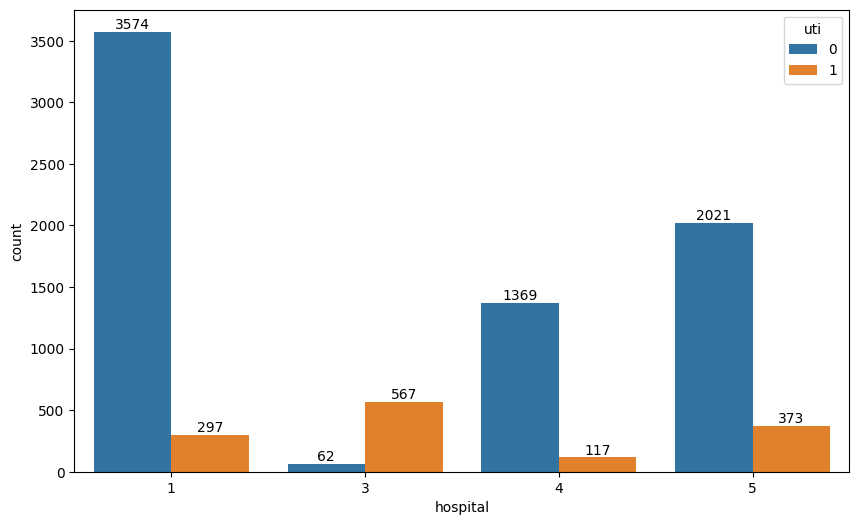

In [288]:
plt.figure(figsize=(10,6))
ax = sns.barplot(y='count',x='hospital',hue='uti',data=df_uti);
for container in ax.containers:
    ax.bar_label(container)

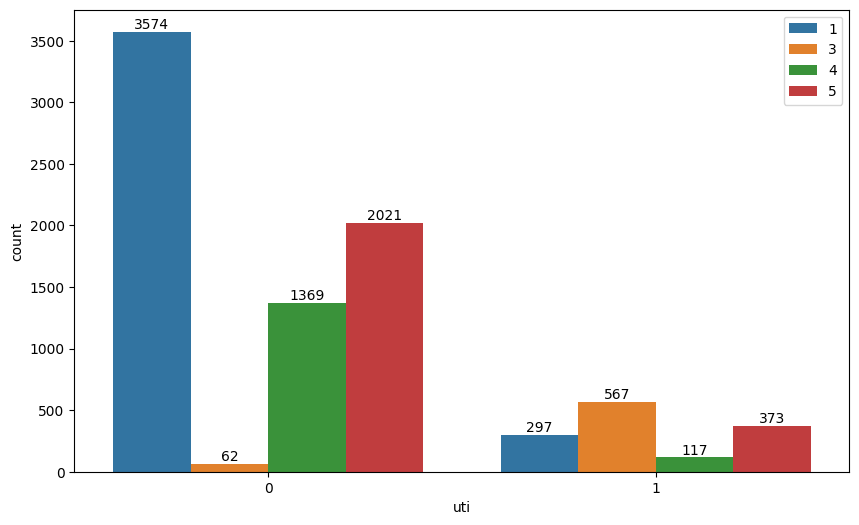

In [289]:
plt.figure(figsize=(10,6))
ax = sns.barplot(y='count',x='uti',hue='hospital',data=df_uti);
plt.legend()
for container in ax.containers:
    ax.bar_label(container)
plt.show()

In [290]:
columnas= df.loc[:, (df.columns != 'record_id') & (df.columns != 'fecha_ingreso') & (df.columns != 'fecha_alta_irab') & (df.columns != 'fecha_de_nacimiento') & (df.columns != 'fecha_sxrespi') & (df.columns != 'fecha_in_uti') & (df.columns != 'fecha_eg_uti')]
#for i in columnas:
#    df[i].value_counts()
#   print(df[i].value_counts())

Algunos graficos de cantidad de valores de cada variable

C:\Users\Emi\AppData\Local\Temp\ipykernel_9552\3377172277.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,3))


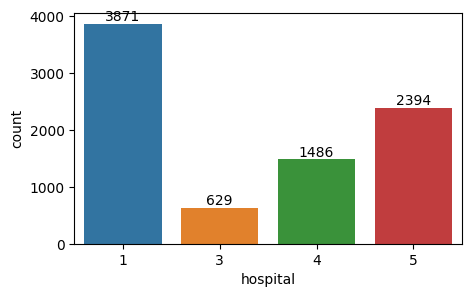

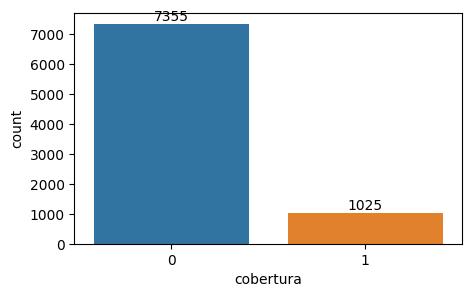

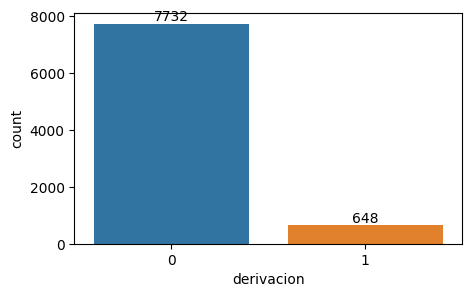

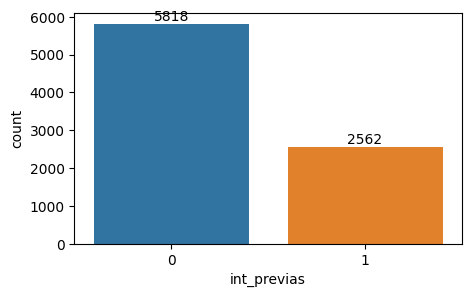

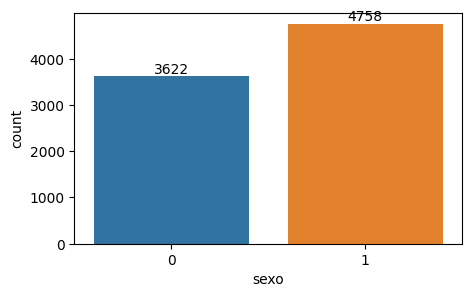

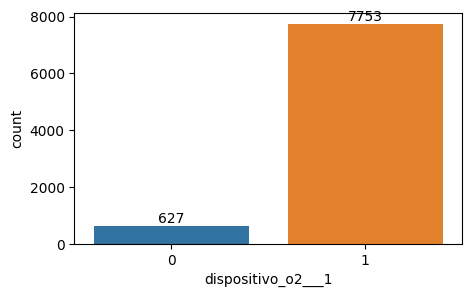

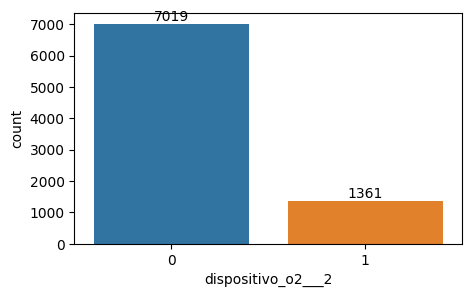

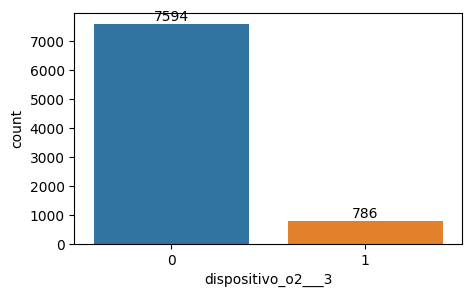

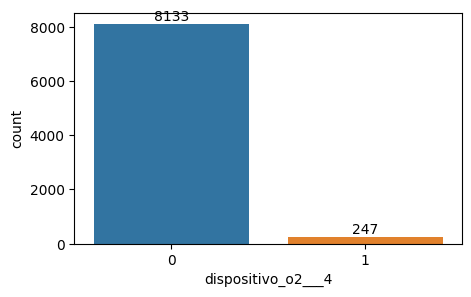

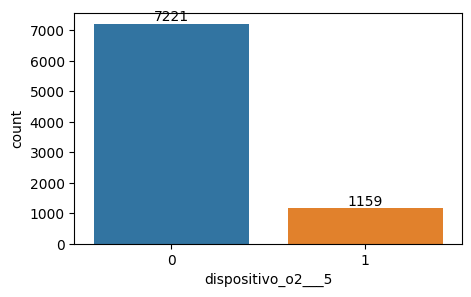

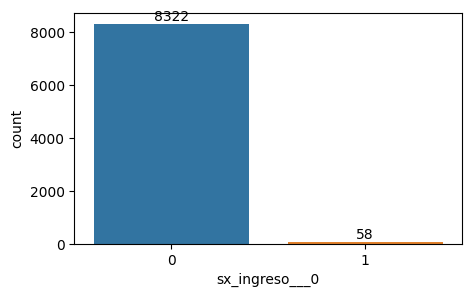

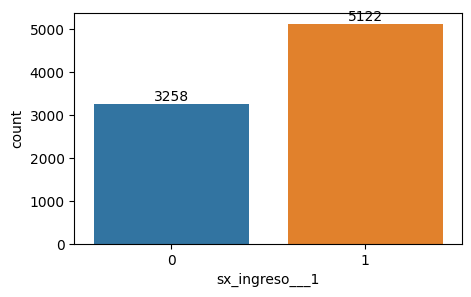

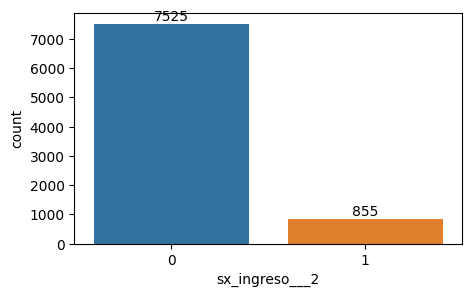

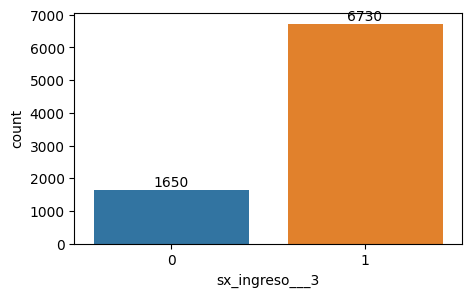

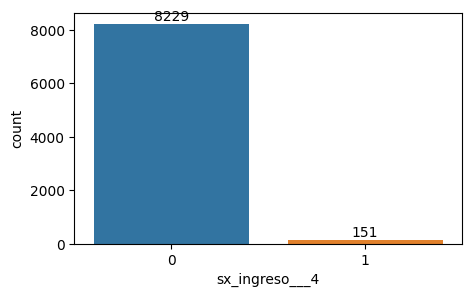

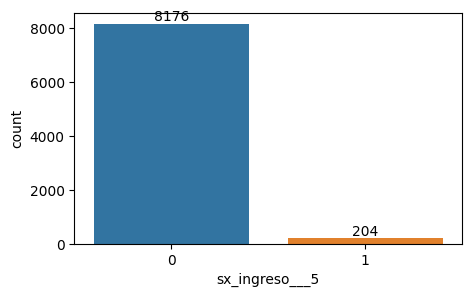

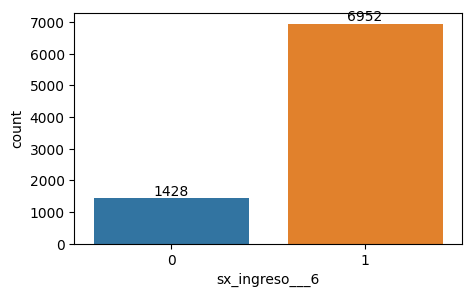

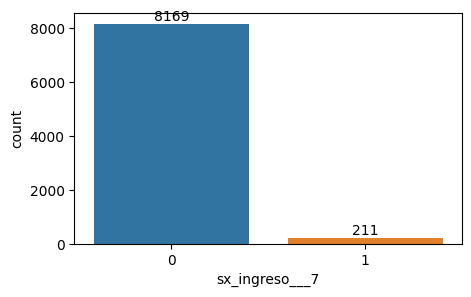

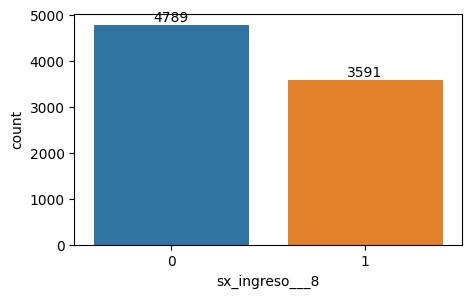

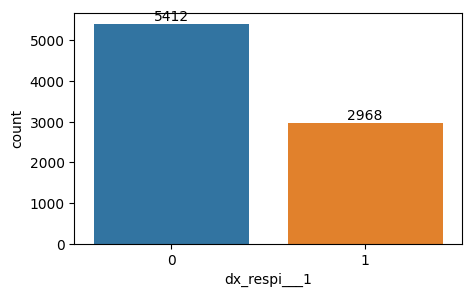

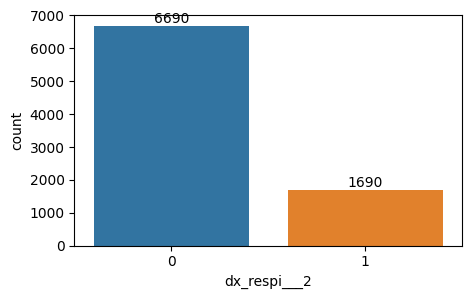

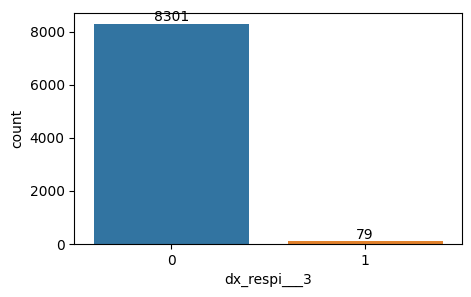

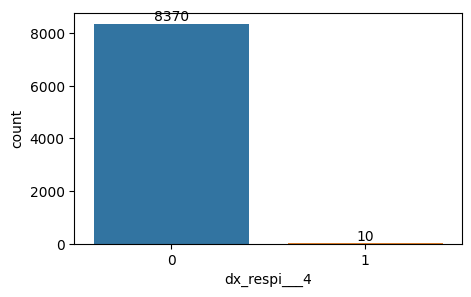

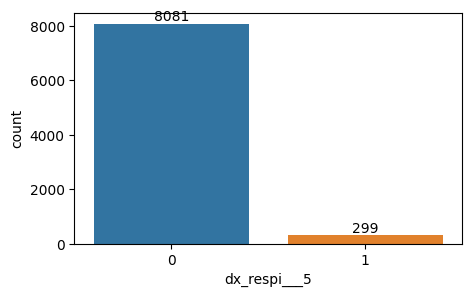

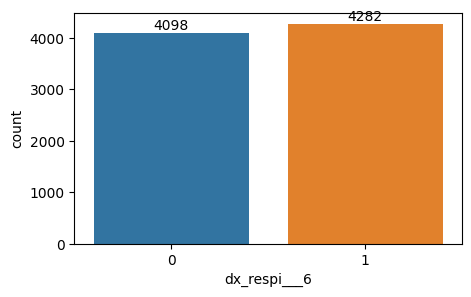

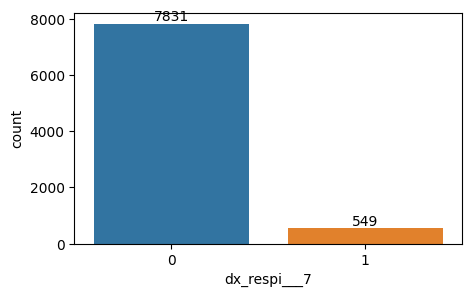

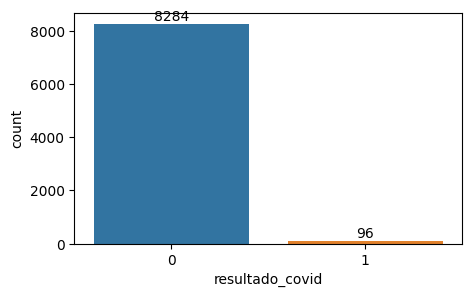

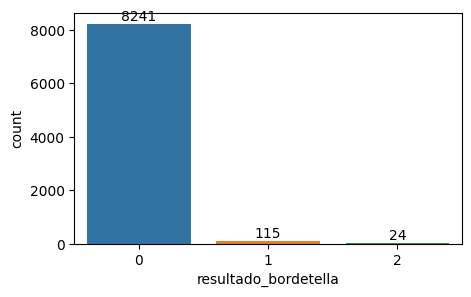

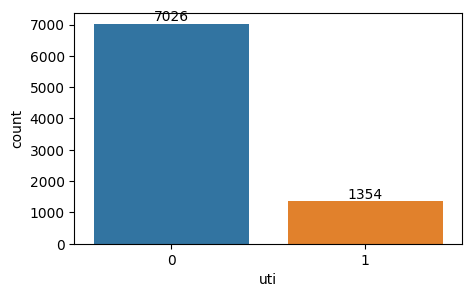

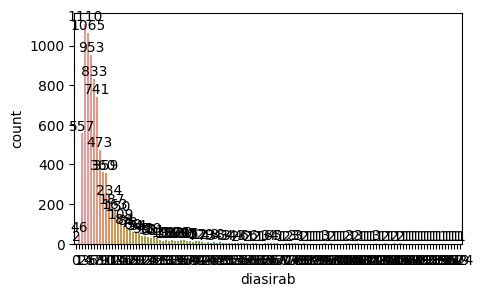

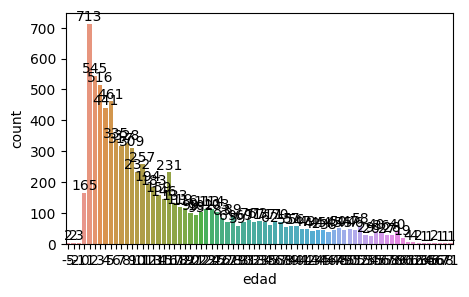

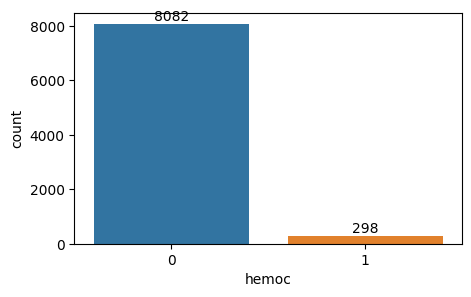

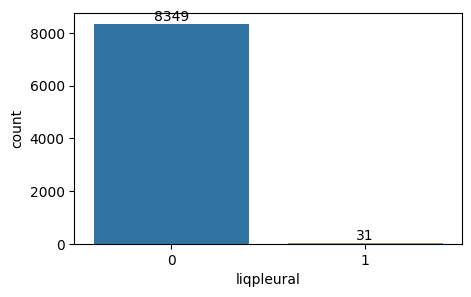

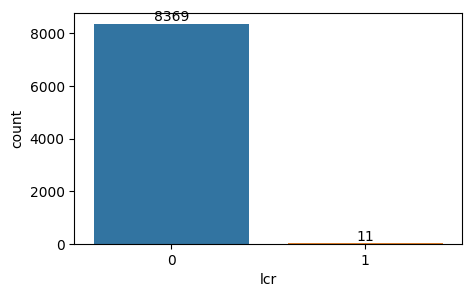

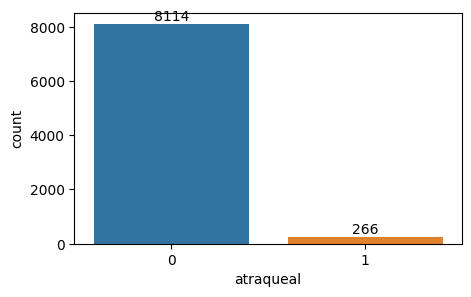

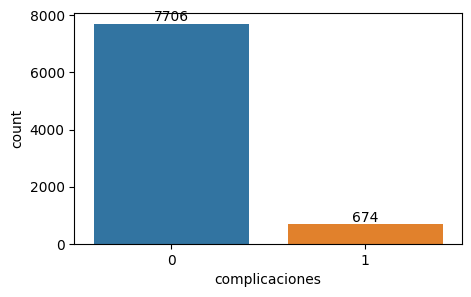

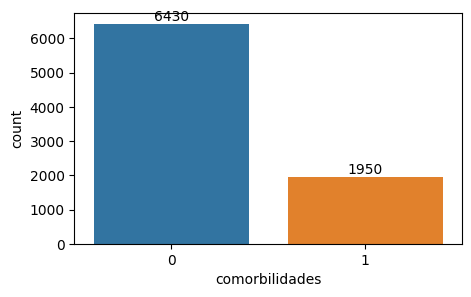

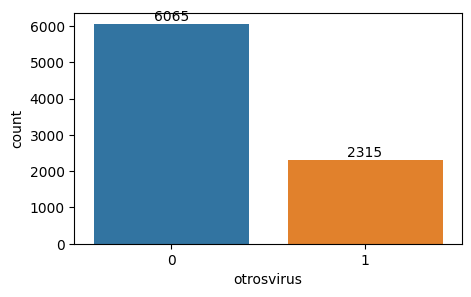

In [291]:
for i in columnas:
    plt.figure(figsize=(5,3))
    ax = sns.countplot(x=columnas[i], data=columnas)
    ax.bar_label(ax.containers[0])

Grafico para ver la distribucion de dias de internacion, separado por hospital, y resultado de Virus sincicial respiratorio

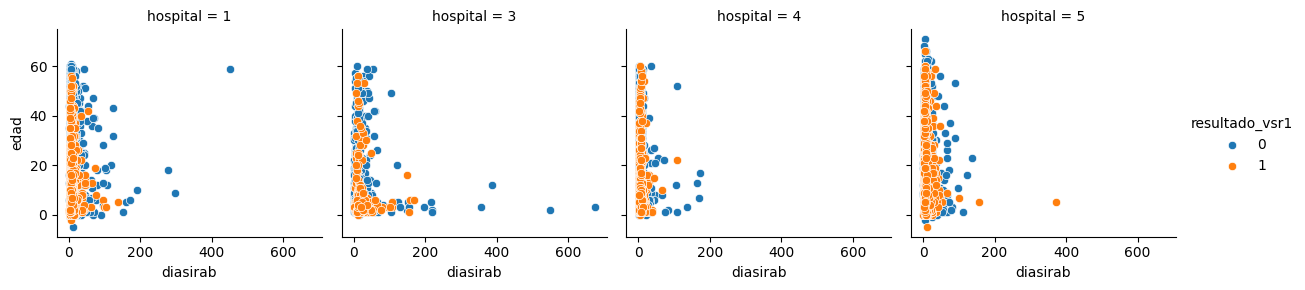

In [292]:
g = sns.FacetGrid(df, col="hospital", hue="resultado_vsr1")
g.map_dataframe(sns.scatterplot, x="diasirab", y="edad")
g.add_legend()

In [293]:
import seaborn.objects as so

In [294]:
df_rsv = df.loc[df["resultado_vsr1"] == 1]

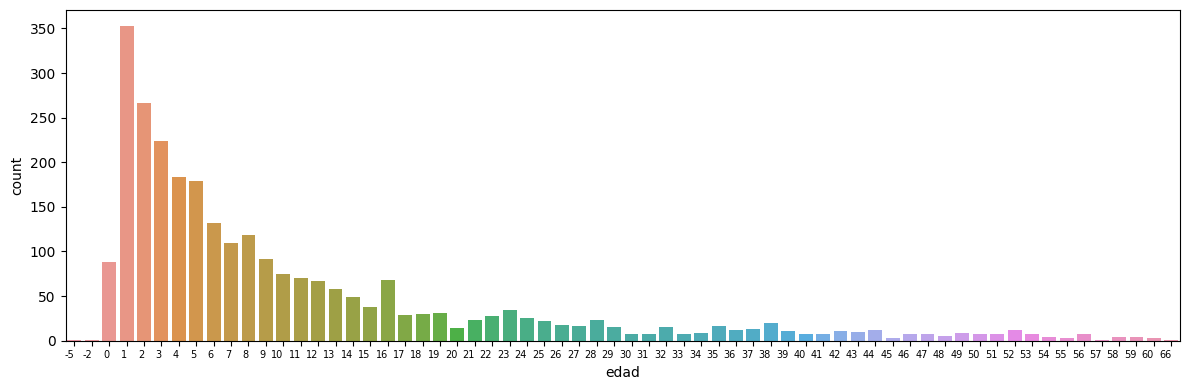

In [295]:
#Distribucion de edad en pacientes con VSR positivo
plt.figure(figsize=(12,4))
ax = sns.countplot(x=df_rsv['edad'], data=df_rsv)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize= 7)
plt.tight_layout()
plt.show()


In [296]:
#Distribucion de edad para todos los pacientes
plt.figure(figsize=(12,4))
ax = sns.countplot(x=columnas['edad'], data=df)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize= 7)
plt.tight_layout()
plt.show()

In [297]:
#Dias irab por hopital y por resultado de test VSR
plt.subplots(figsize=(10,4))
plt.title('Dias irab por hospital')
ax = sns.stripplot(x="hospital", y="diasirab", data=df, hue='resultado_vsr1')
plt.ylabel('Dias irab')
plt.show()

plt.subplots(figsize=(10,4))
plt.title('Dias uti por hospital')
ax = sns.stripplot(x="hospital", y="diasuti", data=df, hue='resultado_vsr1')
plt.ylabel('Dias uti')
plt.show()

In [298]:
#Distribucion de edad por hospital y por resultado de VSR
plt.subplots(figsize=(10,4))
plt.title('Edad por hospital')
ax = sns.stripplot(x="hospital", y="edad", data=df, hue='resultado_vsr1')
plt.ylabel('Edad')
plt.show()

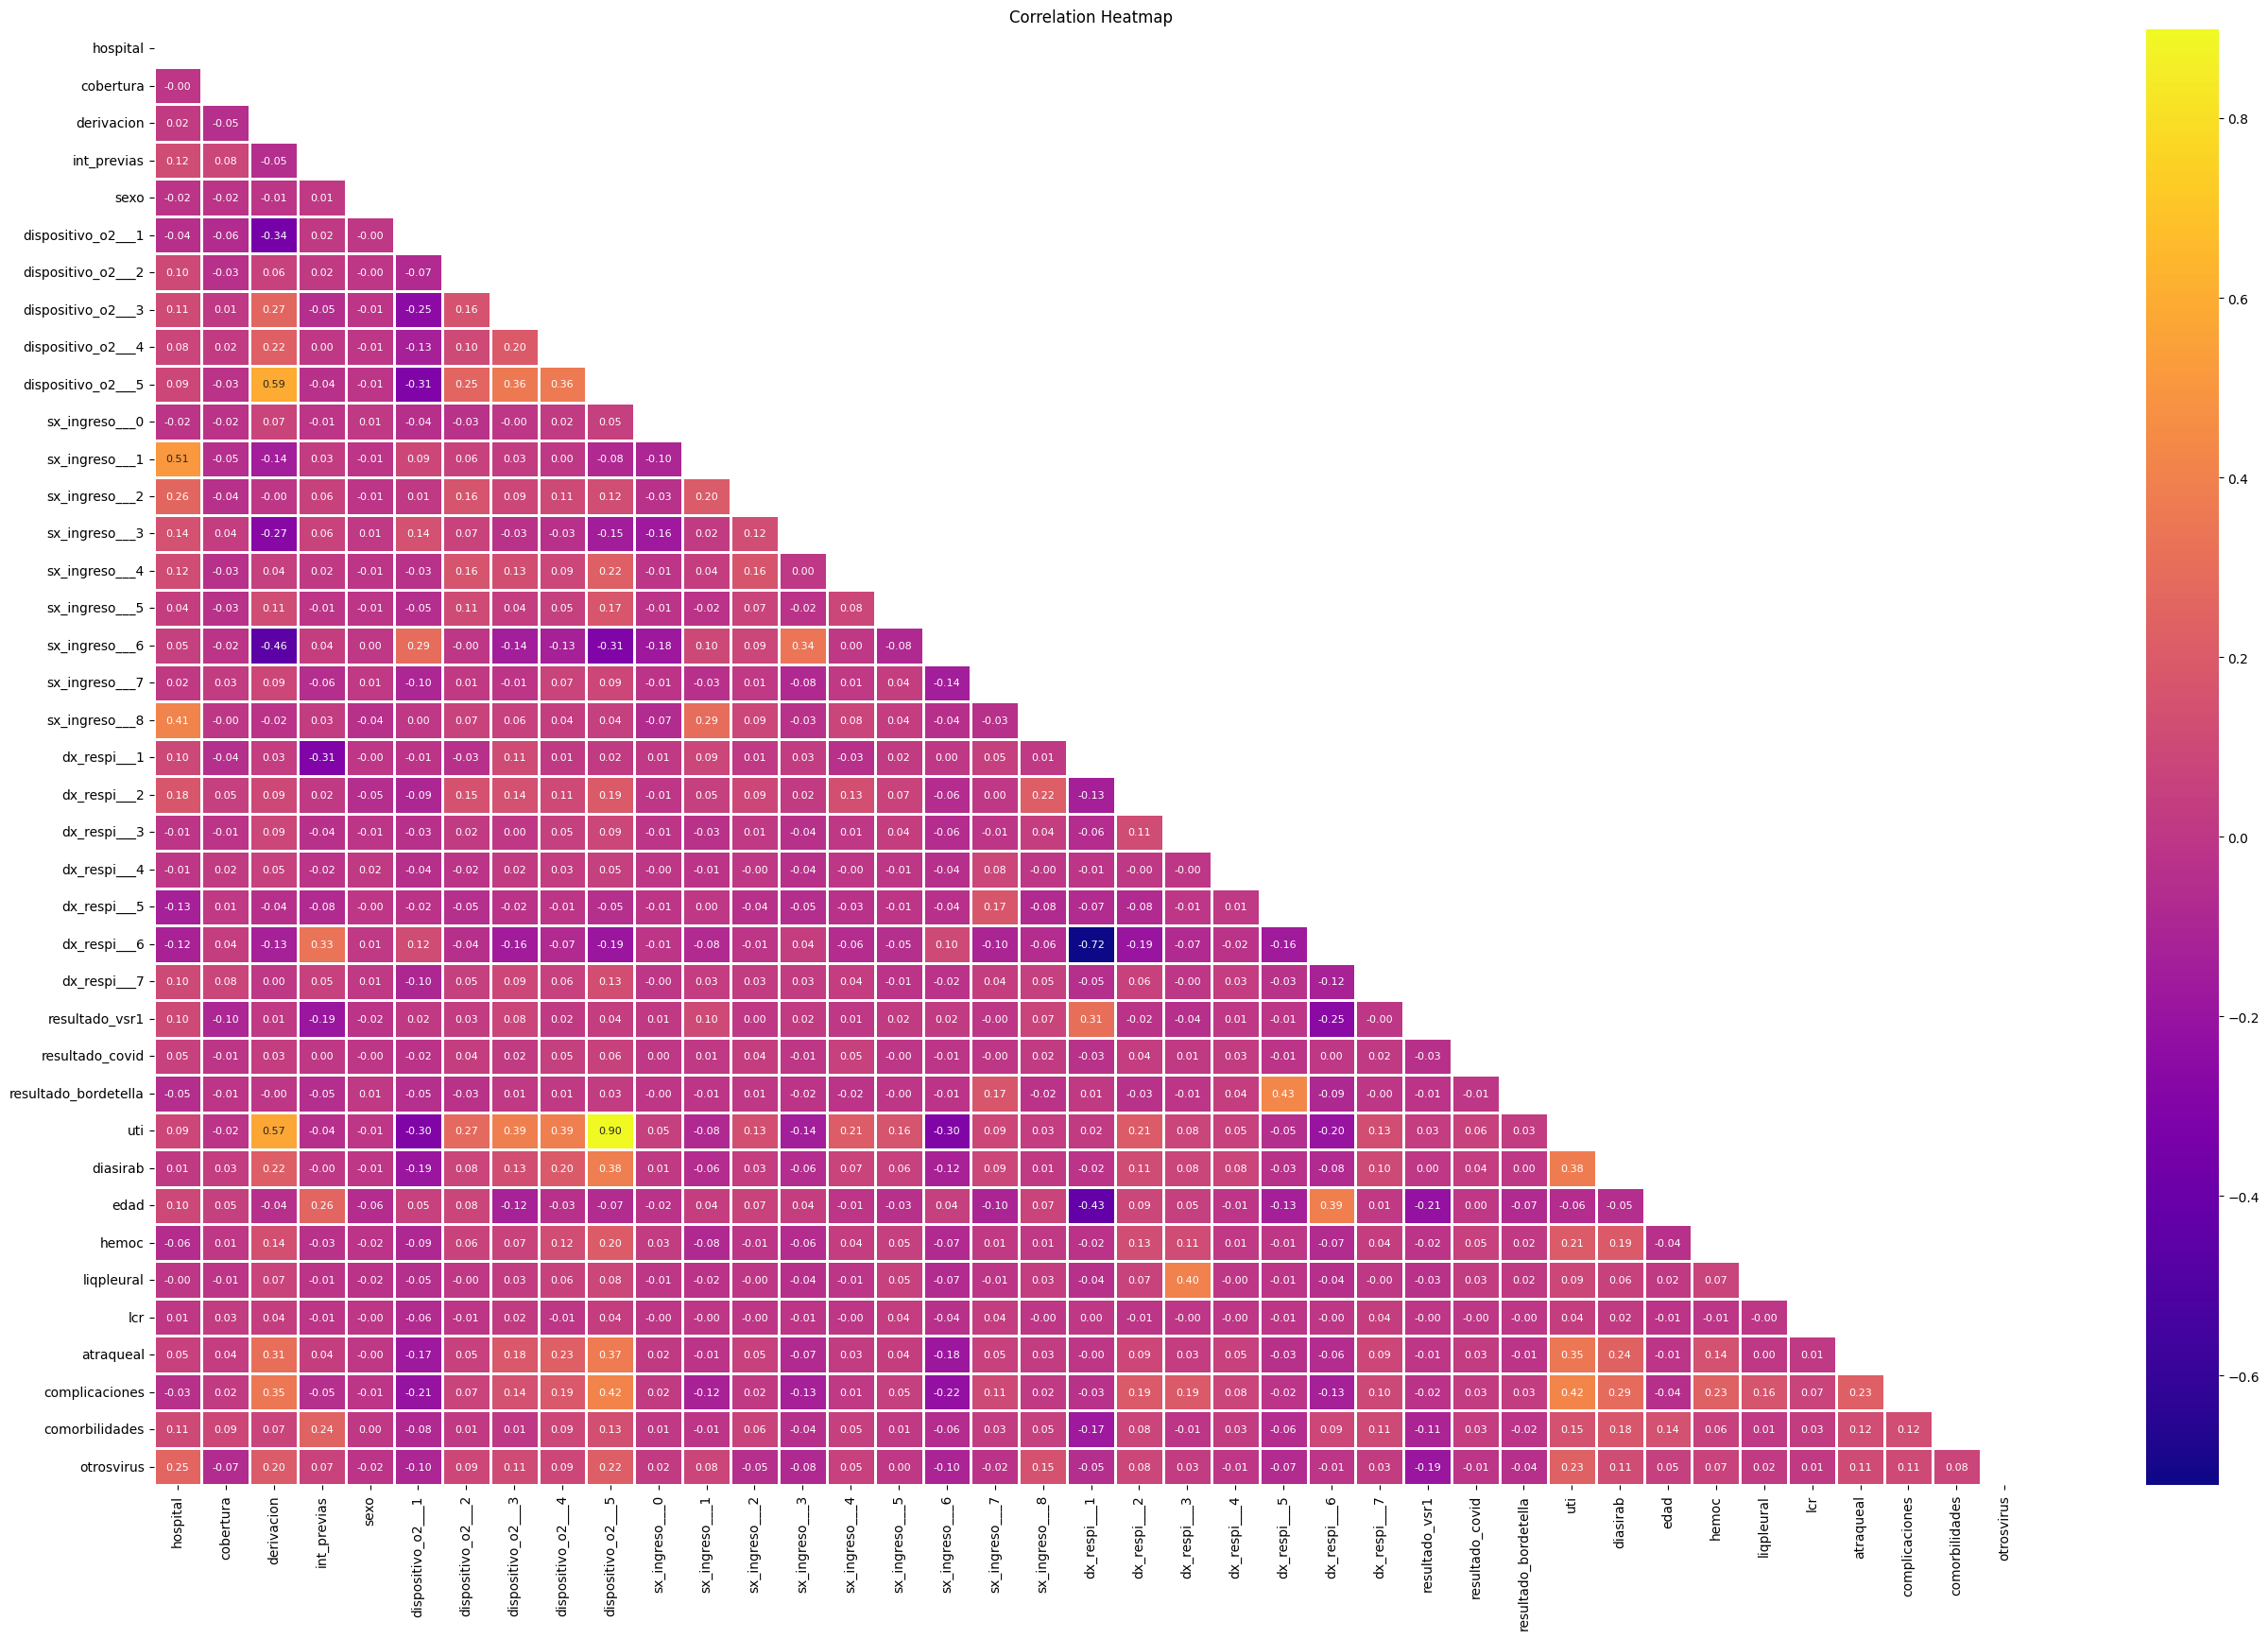

In [299]:
df_ = df.drop('record_id',axis=1)

plt.figure(figsize= (32,20))
mask = np.triu(np.ones_like(df_.corr(),dtype = bool))
sns.heatmap(df_.corr(),mask = mask, fmt = ".2f",annot=True,lw=1,cmap = 'plasma', annot_kws={'size':8})
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlation Heatmap')
plt.show()

Creamos las variables de X e Y para nuestra variable objetivo "UTI"

In [300]:
dummy = pd.DataFrame(df, columns = df.columns)
X = dummy.drop(['uti', 'record_id'], axis=1)       
y = dummy['uti']
dummy.head()

record_id  hospital  cobertura  derivacion  int_previas  sexo   
0  aaa-195-2018-00         4          0           0            0     1  \
1  aaa-264-2020-00         3          0           1            0     0   
2  aaa-264-2020-01         3          0           0            1     0   
3  aaa-306-2019-00         1          0           0            0     0   
4  aaa-437-2018-00         1          0           0            0     0   

   dispositivo_o2___1  dispositivo_o2___2  dispositivo_o2___3   
0                   0                   0                   1  \
1                   0                   0                   1   
2                   0                   0                   0   
3                   1                   1                   0   
4                   1                   0                   0   

   dispositivo_o2___4  ...  uti  diasirab  edad  hemoc  liqpleural  lcr   
0                   0  ...    0         8     2      0           0    0  \
1                   1  ...    1        12     1      0           0    0   
2                   0  ...    0         1     7      0           0    0   
3                   0  ...    0         8     3      0           0    0   
4                   0  ...    0         6    42      0           0    0   

   atraqueal  complicaciones  comorbilidades  otrosvirus  
0          0               0               0           0  
1          0               0               1           0  
2          1               0               1           0  
3          0               0               0           0  
4          0               0               0           1  

[5 rows x 40 columns]

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=60)

Analizamos cual podria ser la profundidad del arbol de decision, que se ajuste mejor a las variables.

In [302]:
A_train = []
A_test = []
for i in range(0,25):
    
    if i == 0:
        i = None
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=60)
    arbol_de_decision = DecisionTreeClassifier(max_depth=i, random_state = 11)
    arbol_de_decision.fit(X_train,y_train)
    y_train_pred = arbol_de_decision.predict(X_train)
    y_test_pred = arbol_de_decision.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    A_train.append(train_accuracy)
    A_test.append(test_accuracy)

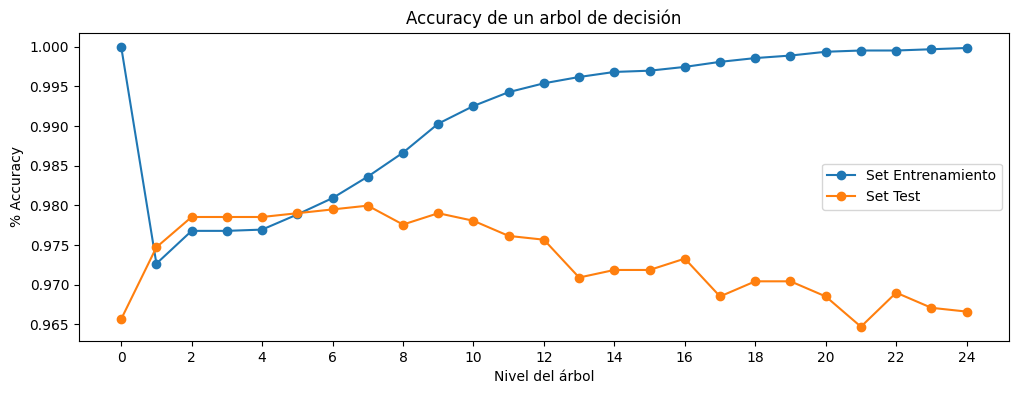

In [303]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(A_train,marker='o', label='Set Entrenamiento')
ax.plot(A_test,marker='o', label='Set Test', color='C1')

ax.set_xlabel('Nivel del árbol')
ax.set_xticks(range(0,26,2))
ax.set_ylabel('% Accuracy')
ax.set_title('Accuracy de un arbol de decisión')
ax.legend()

Se puede observar que el puntaje de accuracy para la mayoria de las profundidades es bastante alto. Esto podria deberse a que la distribucion de nmuestra variable necesite ser ajustada (Lo hacemos mas adelante). Por el momento vamos a elegir un modelo de arbol de decision con profundidad 5.

In [304]:
arbol_de_decision = DecisionTreeClassifier(max_depth=5, random_state = 42, class_weight='balanced') 
arbol_de_decision.fit(X_train,y_train) 
y_train_pred = arbol_de_decision.predict(X_train) 
y_test_pred = arbol_de_decision.predict(X_test) 



In [305]:
arbol_acc_train = accuracy_score(y_train, y_train_pred)
arbol_acc_test = accuracy_score(y_test, y_test_pred)
arbol_prec_train = round(precision_score(y_train, y_train_pred),3)
arbol_prec_test = round(precision_score(y_test, y_test_pred),3)
arbol_recall_train = round(recall_score(y_train, y_train_pred),3)
arbol_recall_test = round(recall_score(y_test, y_test_pred),3)

d = {'arbol_train':[arbol_acc_train,arbol_prec_train,arbol_recall_train],
     'arbol_test':[arbol_acc_test,arbol_prec_test,arbol_recall_test]}

arbol = pd.DataFrame(d, index = ['Accuracy','Precision','Recall'])
arbol


arbol_train  arbol_test
Accuracy      0.965155    0.962291
Precision     0.863000    0.845000
Recall        0.932000    0.938000

In [306]:
confusion_matrix(y_test, y_test_pred) 


array([[1700,   58],
       [  21,  316]], dtype=int64)

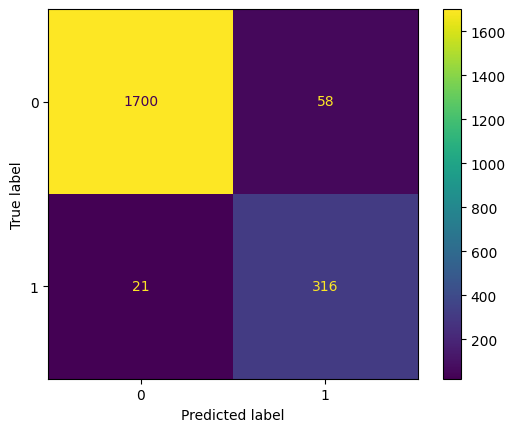

In [307]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

Como se ve tanto en los puntajes como en la matriz, los resultados son bastante buenos para este modelo.

Hacemos lo mismo para un algoritmo de random forest y la cantidad de estimadores.

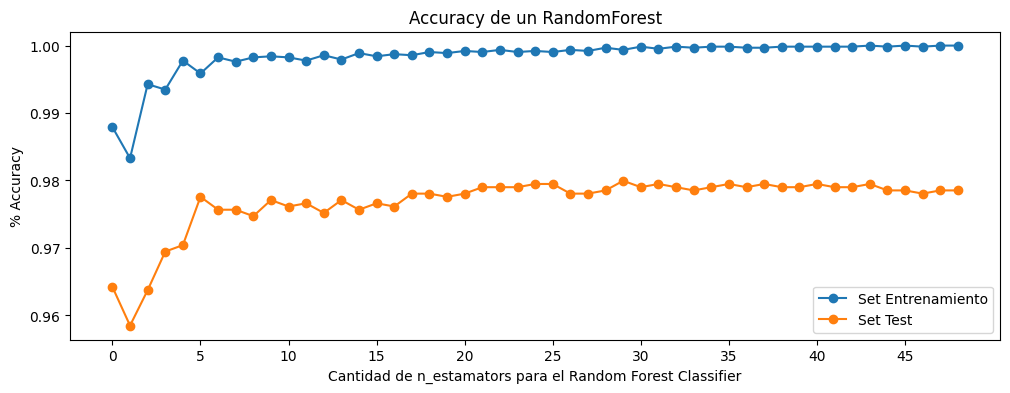

In [308]:
A_train = []
A_test = []

for i in range(1,50):
    
    #Creamos el modelo
    random_forest_model = RandomForestClassifier(n_estimators = i, random_state = 42) 
    #Entrenamos el modelo
    random_forest_model.fit(X_train,y_train) 
    #Prediccion en Train y Test
    y_train_pred = random_forest_model.predict(X_train)
    y_test_pred = random_forest_model.predict(X_test) 
    #Calculo el accuracy en Train y Test
    train_accuracy = accuracy_score(y_train, y_train_pred) 
    test_accuracy = accuracy_score(y_test, y_test_pred) 
    
    # Acumulo los resultados de Accuracy para cada corrida:
    
    A_train.append(train_accuracy)
    A_test.append(test_accuracy)
    
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(A_train,marker='o', label='Set Entrenamiento')
ax.plot(A_test,marker='o', label='Set Test', color='C1')

ax.set_xlabel('Cantidad de n_estamators para el Random Forest Classifier')
ax.set_xticks(range(0,50,5))
ax.set_ylabel('% Accuracy')
#ax.set_ylim(0, 1.1)
ax.set_title('Accuracy de un RandomForest')
ax.legend()

Para este algoritmo se ve claramente que se produce un overfitting. Quizas por el desbalance de la variable objetivo.

Ahora con una cantidad de 7 estimadores, buscamos cual podria ser la profundidad optima para el algoritmo de random forest.

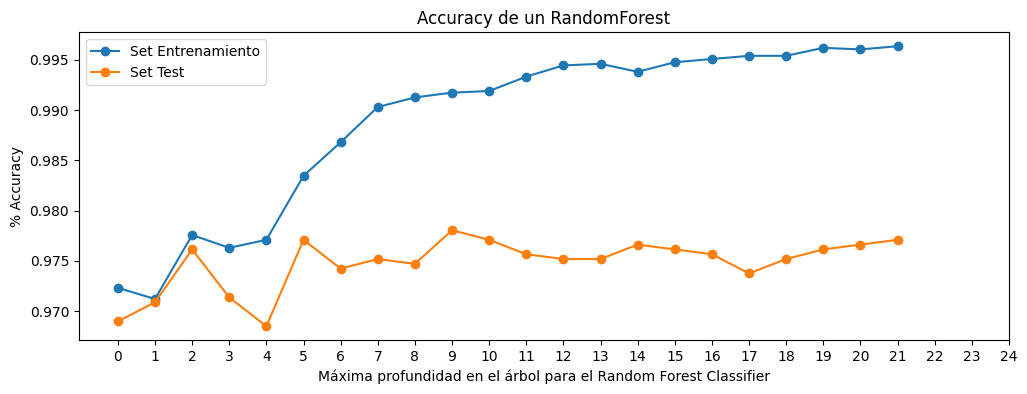

In [309]:


A_train = []
A_test = []

for i in range(3,25):
    
    random_forest_model = RandomForestClassifier(n_estimators = 6,  class_weight="balanced",
                                                 max_depth = i, random_state = 42) 
    random_forest_model.fit(X_train,y_train) 
    y_train_pred = random_forest_model.predict(X_train) 
    y_test_pred = random_forest_model.predict(X_test) 
    train_accuracy = accuracy_score(y_train, y_train_pred) 
    test_accuracy = accuracy_score(y_test, y_test_pred) 
    
    
    A_train.append(train_accuracy)
    A_test.append(test_accuracy)
    
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(A_train,marker='o', label='Set Entrenamiento')
ax.plot(A_test,marker='o', label='Set Test', color='C1')

ax.set_xlabel('Máxima profundidad en el árbol para el Random Forest Classifier')
ax.set_xticks(range(0,25,1))
ax.set_ylabel('% Accuracy')
ax.set_title('Accuracy de un RandomForest')
ax.legend()



Corremos un algoritmo con 6 estimadores y una profundidad de 7.

In [310]:
random_forest_model = RandomForestClassifier(n_estimators=6,
                                             max_depth =7, 
                                             random_state=42,
                                             max_features="log2")
random_forest_model.fit(X_train, y_train) 
y_train_pred_random_forest_model = random_forest_model.predict(X_train) 
y_test_pred_random_forest_model = random_forest_model.predict(X_test)
forest_acc_train = accuracy_score(y_train, y_train_pred_random_forest_model)
forest_acc_test = accuracy_score(y_test, y_test_pred_random_forest_model)
forest_prec_train = round(precision_score(y_train, y_train_pred_random_forest_model),3)
forest_prec_test = round(precision_score(y_test, y_test_pred_random_forest_model),3)
forest_recall_train = round(recall_score(y_train, y_train_pred_random_forest_model),3)
forest_recall_test = round(recall_score(y_test, y_test_pred_random_forest_model),3)

e = {'forest_train':[forest_acc_train,forest_prec_train,forest_recall_train],
     'forest_test':[forest_acc_test,forest_prec_test,forest_recall_test]}

forest = pd.DataFrame(e, index = ['Accuracy','Precision','Recall'])
forest


forest_train  forest_test
Accuracy       0.977566     0.974224
Precision      0.987000     0.976000
Recall         0.873000     0.861000

In [311]:
confusion_matrix(y_test, y_test_pred_random_forest_model) 

array([[1751,    7],
       [  47,  290]], dtype=int64)

In [312]:
cm = confusion_matrix(y_test, y_test_pred_random_forest_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

Tambien para este algoritmo los puntajes son bastante altos.

Creamos un algoritmo de regresion logistica.

In [313]:

regresion_logistica = LogisticRegression()
regresion_logistica.fit(X_train, y_train) 
y_train_pred_regresion_logistica = regresion_logistica.predict(X_train) 
y_test_pred_regresion_logistica = regresion_logistica.predict(X_test)
lr_acc_train = accuracy_score(y_train, y_train_pred_regresion_logistica)
lr_acc_test = accuracy_score(y_test, y_test_pred_regresion_logistica)
lr_prec_train = round(precision_score(y_train, y_train_pred_regresion_logistica),3)
lr_prec_test = round(precision_score(y_test, y_test_pred_regresion_logistica),3)
lr_recall_train = round(recall_score(y_train, y_train_pred_regresion_logistica),3)
lr_recall_test = round(recall_score(y_test, y_test_pred_regresion_logistica),3)

f = {'lr_train':[lr_acc_train,lr_prec_train,lr_recall_train],
     'lr_test':[lr_acc_test,lr_prec_test,lr_recall_test]}

lr = pd.DataFrame(f, index = ['Accuracy','Precision','Recall'])
lr


c:\Users\Emi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


lr_train   lr_test
Accuracy   0.976452  0.975656
Precision  0.973000  0.961000
Recall     0.879000  0.884000

In [314]:
confusion_matrix(y_test, y_test_pred_regresion_logistica) 

array([[1746,   12],
       [  39,  298]], dtype=int64)

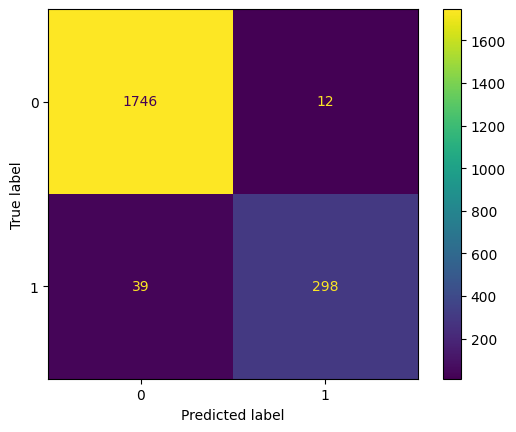

In [315]:
cm = confusion_matrix(y_test, y_test_pred_regresion_logistica)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

Todos los puntajes arriba de 0.9

In [316]:
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 5)
classifier.fit(X_train, y_train)
y_train_pred_knn = classifier.predict(X_train) 
y_test_pred_knn = classifier.predict(X_test)
knn_acc_train = accuracy_score(y_train, y_train_pred_knn)
knn_acc_test = accuracy_score(y_test, y_test_pred_knn)
knn_prec_train = round(precision_score(y_train, y_train_pred_knn),3)
knn_prec_test = round(precision_score(y_test, y_test_pred_knn),3)
knn_recall_train = round(recall_score(y_train, y_train_pred_knn),3)
knn_recall_test = round(recall_score(y_test, y_test_pred_knn),3)

g = {'knn_train':[knn_acc_train,knn_prec_train,knn_recall_train],
     'knn_test':[knn_acc_test,knn_prec_test,knn_recall_test]}

knn = pd.DataFrame(g, index = ['Accuracy','Precision','Recall'])
knn

knn_train  knn_test
Accuracy    0.939857  0.925537
Precision   0.879000  0.818000
Recall      0.729000  0.691000

Para el algoritmo de knn, podemos ver que las metricas del set de test, bajan bastante respecto al set de entrenamiento.

In [317]:
xgb_model = xgboost.XGBClassifier(objective='binary:logistic', 
                                  n_estimators=10,
                                  seed=42,
                                  max_depth=6, 
                                  learning_rate=0.01)

xgb_model.fit(X_train,y_train.squeeze().values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [318]:
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

xgb_acc_train = accuracy_score(y_train, y_train_pred_xgb)
xgb_acc_test = accuracy_score(y_test, y_test_pred_xgb)
xgb_prec_train = round(precision_score(y_train, y_train_pred_xgb),3)
xgb_prec_test = round(precision_score(y_test, y_test_pred_xgb),3)
xgb_recall_train = round(recall_score(y_train, y_train_pred_xgb),3)
xgb_recall_test = round(recall_score(y_test, y_test_pred_xgb),3)

h = {'xgb_train':[xgb_acc_train,xgb_prec_train,xgb_recall_train],
     'xgb_test':[xgb_acc_test,xgb_prec_test,xgb_recall_test]}

xgb = pd.DataFrame(h, index = ['Accuracy','Precision','Recall'])
xgb

xgb_train  xgb_test
Accuracy     0.98043  0.978998
Precision    0.95600  0.956000
Recall       0.92100  0.911000

Las metricas siguen teniendo puntajes altos.

In [319]:
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb_model.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)
xgb_feature_importances.head(10)

name     score
0  dispositivo_o2___5  0.931855
1  dispositivo_o2___4  0.032485
2            hospital  0.007833
3          derivacion  0.006565
4            diasirab  0.006225
5  dispositivo_o2___3  0.003265
6        dx_respi___6  0.002571
7      sx_ingreso___3  0.001599
8      sx_ingreso___7  0.001581
9          otrosvirus  0.001392

Con esta tabla podemos ver como con el XGBoost, declara que la variable de dispositivo de oxigeno numero 5 (Asistencia respiratoria mecanica), tiene mucha importancia para nuestro algoritmo.

In [320]:
#Comparamos las metricas de todos nuestros algoritmos
cuadro = pd.concat([arbol, forest, lr, knn, xgb], axis=1, join='inner')
cuadro 

arbol_train  arbol_test  forest_train  forest_test  lr_train   
Accuracy      0.965155    0.962291      0.977566     0.974224  0.976452  \
Precision     0.863000    0.845000      0.987000     0.976000  0.973000   
Recall        0.932000    0.938000      0.873000     0.861000  0.879000   

            lr_test  knn_train  knn_test  xgb_train  xgb_test  
Accuracy   0.975656   0.939857  0.925537    0.98043  0.978998  
Precision  0.961000   0.879000  0.818000    0.95600  0.956000  
Recall     0.884000   0.729000  0.691000    0.92100  0.911000

Con las metricas de la mayoria de los algoritmos por encima de un 0.9 de puntaje, probamos haciendo un oversampling de nuestro dataset, para descartar que los resultados no se deban al desbalance que tiene nuestra variable objetivo.

In [321]:
print("Tamaño dataset original:",  df['record_id'].value_counts().sum() , "registros")
print(' ')
print('Tamaño de la división Train/Test original:')
print('X_train = ', X_train.shape)
print('y_train = ', y_train.shape)
print('X_test = ', X_test.shape)
print('y_test = ', y_test.shape)

Tamaño dataset original: 8380 registros
 
Tamaño de la división Train/Test original:
X_train =  (6285, 38)
y_train =  (6285,)
X_test =  (2095, 38)
y_test =  (2095,)


In [322]:
Train = pd.concat([X_train, y_train], axis=1)
utino = Train[Train.uti==0]
utisi = Train[Train.uti==1]
utiresample= resample(utisi, 
                             replace=True,
                             n_samples=len(utino),
                             random_state=27)
utiresample.shape

(5268, 39)

In [323]:
upsampled = pd.concat([utino, utiresample])
upsampled.uti.value_counts()

uti
0    5268
1    5268
Name: count, dtype: int64

In [324]:
X_train = upsampled.drop('uti', axis=1)
y_train = upsampled.uti

print('Tamaño de la división Train/Test considerando Oversampling en la clase minoritaria:')
print('X_train = ', X_train.shape)
print('y_train = ', y_train.shape)
print('X_test = ', X_test.shape)
print('y_test = ', y_test.shape)

Tamaño de la división Train/Test considerando Oversampling en la clase minoritaria:
X_train =  (10536, 38)
y_train =  (10536,)
X_test =  (2095, 38)
y_test =  (2095,)


Corremos los mismo algoritmos que hicimos antes, pero ahora con el oversampling aplicado, para ver las diferencias.

In [325]:
arbol_de_decisionr = DecisionTreeClassifier(max_depth=5, random_state = 42, class_weight='balanced') 
arbol_de_decisionr.fit(X_train,y_train) 
y_train_pred = arbol_de_decisionr.predict(X_train) 
y_test_pred = arbol_de_decisionr.predict(X_test) 

In [326]:
res_arbol_acc_train = accuracy_score(y_train, y_train_pred)
res_arbol_acc_test = accuracy_score(y_test, y_test_pred)
res_arbol_prec_train = round(precision_score(y_train, y_train_pred),3)
res_arbol_prec_test = round(precision_score(y_test, y_test_pred),3)
res_arbol_recall_train = round(recall_score(y_train, y_train_pred),3)
res_arbol_recall_test = round(recall_score(y_test, y_test_pred),3)

dr = {'res_arbol_train':[res_arbol_acc_train,res_arbol_prec_train,res_arbol_recall_train],
     'res_arbol_test':[res_arbol_acc_test,res_arbol_prec_test,res_arbol_recall_test]}

arbolr = pd.DataFrame(dr, index = ['Accuracy','Precision','Recall'])
arbolr

res_arbol_train  res_arbol_test
Accuracy          0.949222        0.953699
Precision         0.964000        0.816000
Recall            0.933000        0.920000

In [327]:
confusion_matrix(y_test, y_test_pred) 

array([[1688,   70],
       [  27,  310]], dtype=int64)

In [328]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

In [329]:
random_forest_model = RandomForestClassifier(n_estimators=6,
                                             max_depth =7, 
                                             random_state=42,
                                             max_features="log2")
random_forest_model.fit(X_train, y_train) 
y_train_pred_random_forest_model = random_forest_model.predict(X_train) 
y_test_pred_random_forest_model = random_forest_model.predict(X_test)
res_forest_acc_train = accuracy_score(y_train, y_train_pred_random_forest_model)
res_forest_acc_test = accuracy_score(y_test, y_test_pred_random_forest_model)
res_forest_prec_train = round(precision_score(y_train, y_train_pred_random_forest_model),3)
res_forest_prec_test = round(precision_score(y_test, y_test_pred_random_forest_model),3)
res_forest_recall_train = round(recall_score(y_train, y_train_pred_random_forest_model),3)
res_forest_recall_test = round(recall_score(y_test, y_test_pred_random_forest_model),3)

er = {'res_forest_train':[res_forest_acc_train,res_forest_prec_train,res_forest_recall_train],
     'res_forest_test':[res_forest_acc_test,res_forest_prec_test,res_forest_recall_test]}

forestr = pd.DataFrame(er, index = ['Accuracy','Precision','Recall'])
forestr

res_forest_train  res_forest_test
Accuracy           0.959282         0.968974
Precision          0.987000         0.898000
Recall             0.931000         0.911000

In [330]:
confusion_matrix(y_test, y_test_pred_random_forest_model) 

array([[1723,   35],
       [  30,  307]], dtype=int64)

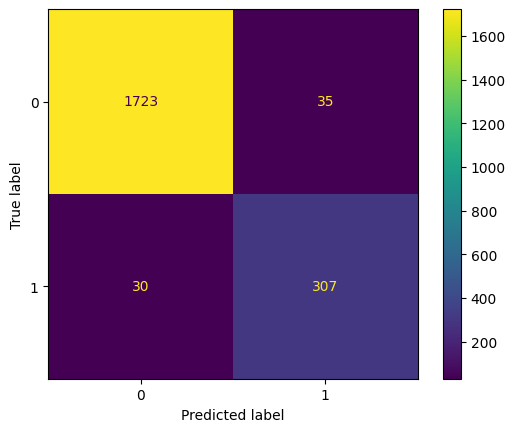

In [331]:
cm = confusion_matrix(y_test, y_test_pred_random_forest_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

In [332]:
regresion_logistica = LogisticRegression()
regresion_logistica.fit(X_train, y_train) 
y_train_pred_regresion_logistica = regresion_logistica.predict(X_train) 
y_test_pred_regresion_logistica = regresion_logistica.predict(X_test)
res_lr_acc_train = accuracy_score(y_train, y_train_pred_regresion_logistica)
res_lr_acc_test = accuracy_score(y_test, y_test_pred_regresion_logistica)
res_lr_prec_train = round(precision_score(y_train, y_train_pred_regresion_logistica),3)
res_lr_prec_test = round(precision_score(y_test, y_test_pred_regresion_logistica),3)
res_lr_recall_train = round(recall_score(y_train, y_train_pred_regresion_logistica),3)
res_lr_recall_test = round(recall_score(y_test, y_test_pred_regresion_logistica),3)

fr = {'res_lr_train':[res_lr_acc_train,res_lr_prec_train,res_lr_recall_train],
     'res_lr_test':[res_lr_acc_test,res_lr_prec_test,res_lr_recall_test]}

lrr = pd.DataFrame(fr, index = ['Accuracy','Precision','Recall'])
lrr

c:\Users\Emi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


res_lr_train  res_lr_test
Accuracy       0.953778     0.962291
Precision      0.976000     0.854000
Recall         0.931000     0.923000

In [333]:
confusion_matrix(y_test, y_test_pred_regresion_logistica) 

array([[1705,   53],
       [  26,  311]], dtype=int64)

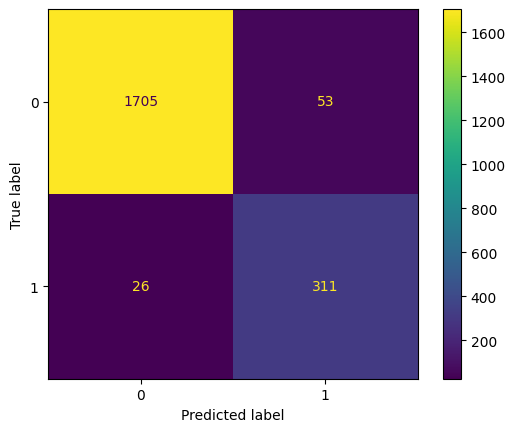

In [334]:
cm = confusion_matrix(y_test, y_test_pred_regresion_logistica)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

In [335]:
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 5)
classifier.fit(X_train, y_train)
y_train_pred_knn = classifier.predict(X_train) 
y_test_pred_knn = classifier.predict(X_test)
res_knn_acc_train = accuracy_score(y_train, y_train_pred_knn)
res_knn_acc_test = accuracy_score(y_test, y_test_pred_knn)
res_knn_prec_train = round(precision_score(y_train, y_train_pred_knn),3)
res_knn_prec_test = round(precision_score(y_test, y_test_pred_knn),3)
res_knn_recall_train = round(recall_score(y_train, y_train_pred_knn),3)
res_knn_recall_test = round(recall_score(y_test, y_test_pred_knn),3)

gr = {'res_knn_train':[res_knn_acc_train,res_knn_prec_train,res_knn_recall_train],
     'res_knn_test':[res_knn_acc_test,res_knn_prec_test,res_knn_recall_test]}

knnr = pd.DataFrame(gr, index = ['Accuracy','Precision','Recall'])
knnr

res_knn_train  res_knn_test
Accuracy        0.972191      0.913604
Precision       0.953000      0.697000
Recall          0.993000      0.819000

In [336]:
confusion_matrix(y_test, y_test_pred_knn) 

array([[1638,  120],
       [  61,  276]], dtype=int64)

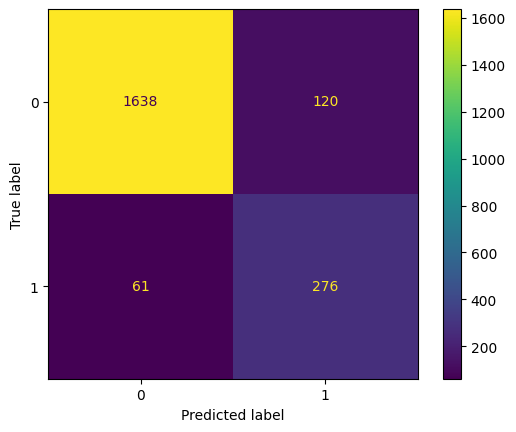

In [337]:
cm = confusion_matrix(y_test, y_test_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot()

plt.show()

In [338]:
xgb_model = xgboost.XGBClassifier(objective='binary:logistic', 
                                  n_estimators=10,
                                  seed=42,
                                  max_depth=6, 
                                  learning_rate=0.01)

xgb_model.fit(X_train,y_train.squeeze().values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [339]:
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

res_xgb_acc_train = accuracy_score(y_train, y_train_pred_xgb)
res_xgb_acc_test = accuracy_score(y_test, y_test_pred_xgb)
res_xgb_prec_train = round(precision_score(y_train, y_train_pred_xgb),3)
res_xgb_prec_test = round(precision_score(y_test, y_test_pred_xgb),3)
res_xgb_recall_train = round(recall_score(y_train, y_train_pred_xgb),3)
res_xgb_recall_test = round(recall_score(y_test, y_test_pred_xgb),3)

hr = {'res_xgb_train':[res_xgb_acc_train,res_xgb_prec_train,res_xgb_recall_train],
     'res_xgb_test':[res_xgb_acc_test,res_xgb_prec_test,res_xgb_recall_test]}

xgbr = pd.DataFrame(hr, index = ['Accuracy','Precision','Recall'])
xgbr

res_xgb_train  res_xgb_test
Accuracy        0.962225        0.9642
Precision       0.972000        0.8520
Recall          0.952000        0.9410

In [340]:
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb_model.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)
xgb_feature_importances.head(10)

name     score
0  dispositivo_o2___5  0.878140
1  dispositivo_o2___4  0.056480
2            diasirab  0.014305
3  dispositivo_o2___3  0.012593
4      complicaciones  0.011213
5            hospital  0.007773
6          derivacion  0.007719
7        dx_respi___6  0.005117
8        dx_respi___4  0.003349
9           cobertura  0.002495

In [341]:
cuadro2 = pd.concat([arbol, arbolr, forest, forestr, lr, lrr, knn, knnr, xgb, xgbr], axis=1, join='inner')
cuadro2 

arbol_train  arbol_test  res_arbol_train  res_arbol_test   
Accuracy      0.965155    0.962291         0.949222        0.953699  \
Precision     0.863000    0.845000         0.964000        0.816000   
Recall        0.932000    0.938000         0.933000        0.920000   

           forest_train  forest_test  res_forest_train  res_forest_test   
Accuracy       0.977566     0.974224          0.959282         0.968974  \
Precision      0.987000     0.976000          0.987000         0.898000   
Recall         0.873000     0.861000          0.931000         0.911000   

           lr_train   lr_test  res_lr_train  res_lr_test  knn_train  knn_test   
Accuracy   0.976452  0.975656      0.953778     0.962291   0.939857  0.925537  \
Precision  0.973000  0.961000      0.976000     0.854000   0.879000  0.818000   
Recall     0.879000  0.884000      0.931000     0.923000   0.729000  0.691000   

           res_knn_train  res_knn_test  xgb_train  xgb_test  res_xgb_train   
Accuracy        0.972191      0.913604    0.98043  0.978998       0.962225  \
Precision       0.953000      0.697000    0.95600  0.956000       0.972000   
Recall          0.993000      0.819000    0.92100  0.911000       0.952000   

           res_xgb_test  
Accuracy         0.9642  
Precision        0.8520  
Recall           0.9410

Como vemos en el cuadro comparativo de las metricas de los algoritmos, los puntajes de los algoritmos utilizados luego de equilibrar nuestra variable objetivo, siguen siendo altos. Por lo que podriamos decir que las variables elgidas, podrian ayudarnos a determinar si un paciente requerira o no ingresar a terapia intensiva.

El algoritmo con mejor desempeño a nuestro criterio, fue el de regresion lineal, luego de haber equilibrado la variable objetivo. <br>
Accuracy: 0.96 <br>
Precision: 0.85 <br>
Recall: 0.92 <br>